In [1]:
import os
os.chdir("/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs")

In [2]:
from pathlib import Path
import json
from tqdm import tqdm
from pathlib import Path
import logging
import argparse
from typing import Any
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### load modules
from src.dataset.utils import load_dataset
from src.models.utils import load_model
from src.logging.logging_config import setup_logging

### load config
from config.default import cfg

### load modules
from src.prompt_generator import PromptGenerator
from src.pipeline import SpatialReasoningPipeline

/home/u5u/kdeng.u5u/miniconda3/envs/spatial_reasoning_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def _load_model(model_id: str):
    """
    Load the model based on the model ID.
    
    """
    model = load_model(model_id)
    model._load_weight()
    return model


def _get_benchmark_name(data_dir: str) -> str:
    """
    Extract the benchmark name from the data directory.
    """
    data_dir = Path(data_dir)
    if data_dir.is_dir():
        return data_dir.parent.name
    else:
        raise ValueError(f"Invalid data directory: {data_dir}")

def _load_dataloader(data_dir: str, cfg: Any):
    """
    Load the dataset and create a DataLoader.
    """
    dataset = load_dataset(_get_benchmark_name(data_dir), data_root_dir=data_dir, cfg=cfg)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=lambda x: x)
    dataloader_tqdm = tqdm(dataloader, desc="Processing", total=len(dataloader) if hasattr(dataloader, '__len__') else None)
    return dataloader_tqdm

In [4]:
data_dir = "/home/u5u/kdeng.u5u/benchmark/single-dof-camera-motion-scannet/theta_significant"
dataloader = _load_dataloader(data_dir, cfg)

# Load the model
# vlm_id = "claude-opus-4-20250514"
vlm_id = "claude-sonnet-4-20250514"
vlm = _load_model(vlm_id)

batch = next(iter(dataloader))
item = next(iter(batch))  # get the first item in the batch

src_img, tgt_img = item["source_image"], item["target_image"]
metadata = item["metadata"]
images = (src_img, tgt_img)

vlm._clear_history()  # clear the history of VLM for each pair of images

prompt = "What do you see?"
    
vlm_answer = vlm.pipeline(images, prompt)

Dataset length count exceeded 60 for dir /home/u5u/kdeng.u5u/benchmark/single-dof-camera-motion-scannet/theta_significant.
Processing:   0%|          | 0/60 [00:00<?, ?it/s]


BadRequestError: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'Your credit balance is too low to access the Anthropic API. Please go to Plans & Billing to upgrade or purchase credits.'}}

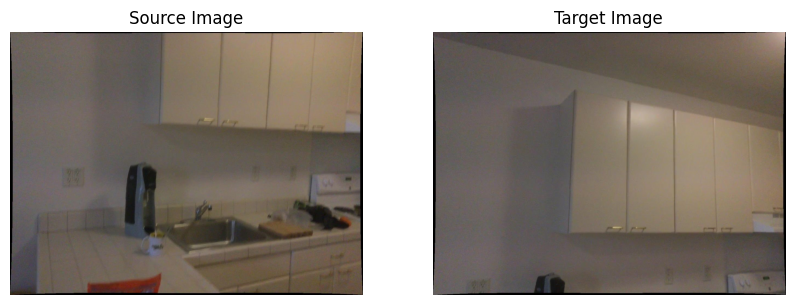

In [ ]:
# plot source image and target image in one figure, note that images in tensor format
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(src_img.permute(1, 2, 0).cpu().numpy())
ax[0].set_title("Source Image")
ax[0].axis('off')
ax[1].imshow(tgt_img.permute(1, 2, 0).cpu().numpy())
ax[1].set_title("Target Image")
ax[1].axis('off')
plt.show()

In [ ]:
vlm_answer

'I can see two similar images of what appears to be a kitchen area. Both images show:\n\n- White upper kitchen cabinets mounted on the wall\n- A white tile backsplash\n- What looks like a sink area with a faucet\n- Some kitchen appliances or items on the counter\n- White/light colored walls\n- The lighting appears dim or the photos were taken in low light conditions\n\nThe second image appears to be taken from a slightly different angle or distance, showing more of the upper cabinets and less of the counter area compared to the first image. The kitchen has a clean, minimalist appearance with an all-white color scheme.'

In [ ]:
vlm.print_total_tokens_usage()

🤡🤡🤡 Total Cost: 0.012$
